#Начало

In [ ]:
!wget -r -N -c -np https://physionet.org/files/sddb/1.0.0/

In [8]:
!pip install wfdb

In [9]:
import wfdb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
import h5py
from scipy.signal import find_peaks
import scipy.stats
from IPython.display import display
from scipy.signal import butter, lfilter
from scipy.signal import freqs

In [20]:
header = wfdb.rdheader('30')

#Main part

Скачаем данные и выведем сначала весь сигнал, а потом первые 15 секунд.

In [13]:
record = wfdb.rdrecord('physionet.org/files/sddb/1.0.0/30')
signal = record.p_signal[:, 0]
record_fc = record.fs

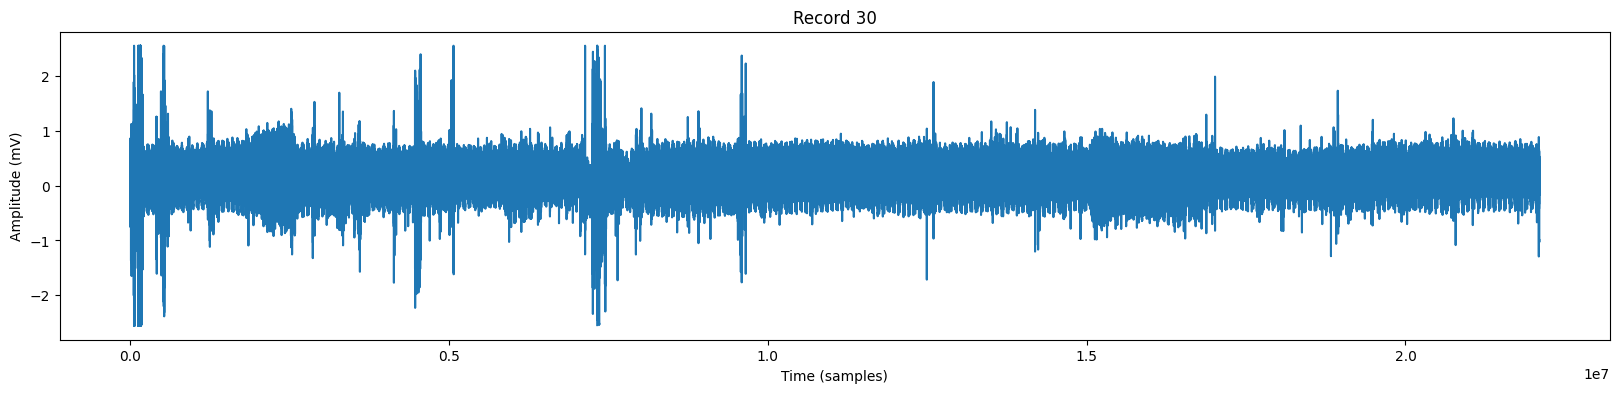

In [14]:
plt.figure(figsize=(20, 4))
plt.plot(signal)
plt.title('Record 30')
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude (mV)')
plt.show()

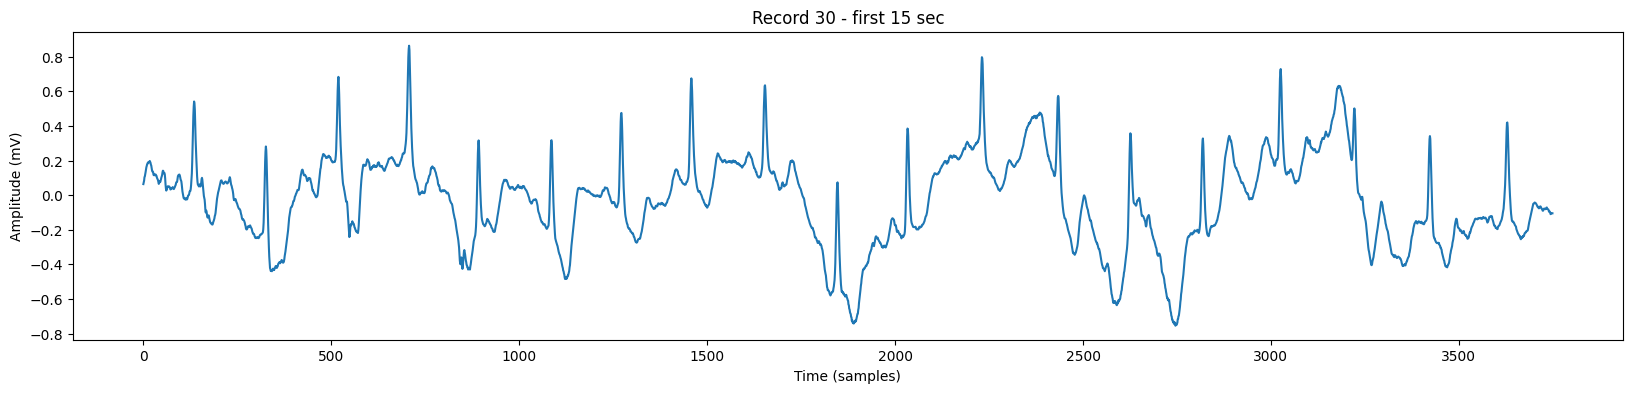

In [15]:
n_samples_per15sec = 15 * record_fc
plt.figure(figsize=(20, 4))
plt.plot(signal[:n_samples_per15sec])
plt.title('Record 30 - first 15 sec')
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude (mV)')
plt.show()

Пробую найти ACF с помощью корреляции сигнала с самим собой (15 секунд)
Вышло как-то не очень...

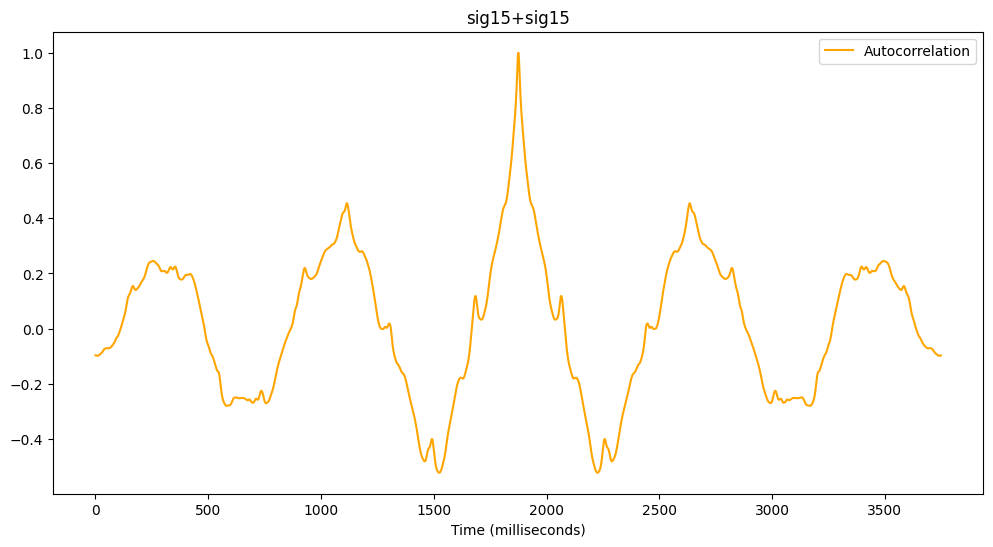

In [27]:
sig_15 = signal[:record_fc * 15]

acf = np.correlate(sig_15, sig_15, mode='same')

acf /= np.max(acf)

plt.figure(figsize=(12, 6))
plt.title('sig15+sig15')
plt.plot(acf, c='orange', label='Autocorrelation')
#plt.plot(sig_15, label='Raw signal')
plt.legend()
plt.xlabel('Time (milliseconds)')
plt.show()

Попробовала еще со смещением времени

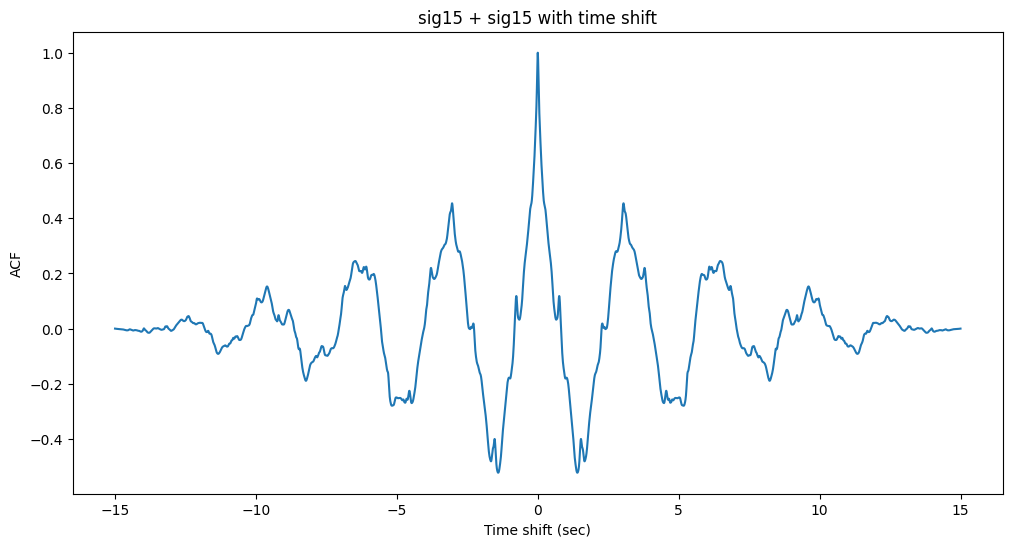

In [30]:
def plot_acf(record, interval):
    signal = record.p_signal[:, 0]
    end_index = int(interval * record.fs)
    selected_signal = signal[0:end_index]
    acf = np.correlate(selected_signal, selected_signal, mode='full')

    time_shift = int(acf.size / 2)
    normalized_acf = acf / acf[time_shift]

    time = np.arange(-time_shift, time_shift + 1) / record.fs


    plt.figure(figsize=(12, 6))
    plt.plot(time, normalized_acf)
    plt.title('sig15 + sig15 with time shift')
    plt.xlabel('Time shift (sec)')
    plt.ylabel('ACF')
    plt.show()
plot_acf(record, 15)

Пробую сделать корреляцию сигнала с синусоидальным фильтром

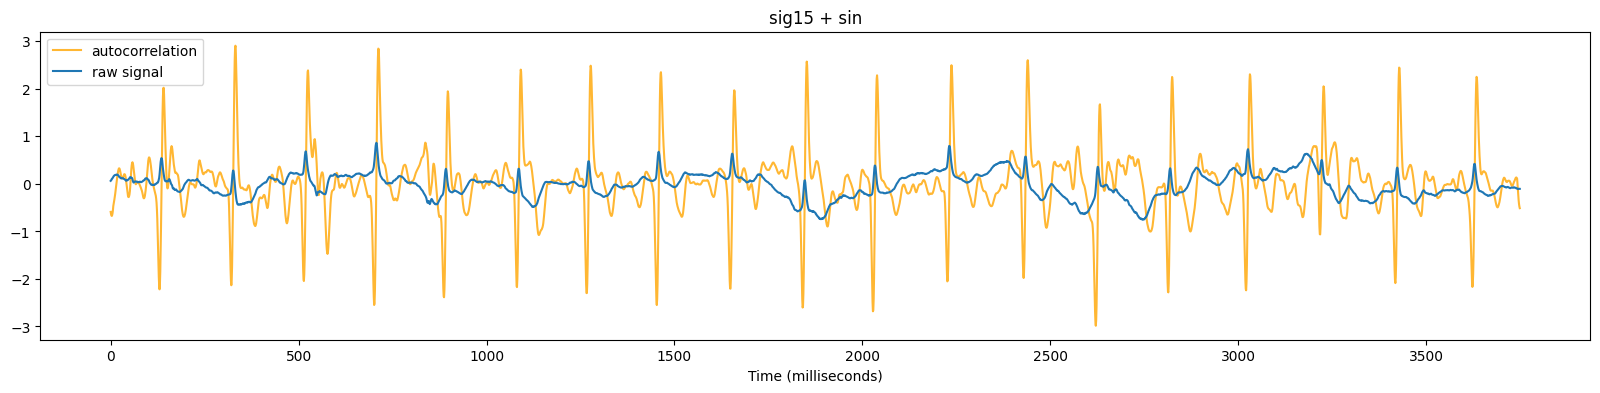

In [53]:
v = np.linspace(0.5 * np.pi, 1.5 * np.pi, 15)

peak_filter = np.sin(v)

acf_sin = np.correlate(sig_15, peak_filter, mode="same")

plt.figure(figsize=(20,4))
plt.title('sig15 + sin')
plt.plot(acf_sin, alpha = 0.8, c='orange')
plt.plot(sig_15, alpha = 1)
plt.gca().legend(('autocorrelation','raw signal'))
plt.xlabel('Time (milliseconds)')
plt.show()

In [74]:
# Можно нормализовать автокорреляцию, на результат ЧСС это не повлияет
#x_transformed /= np.max(x_transformed)

# Нахождение индекса максимального пика в автокорреляции
peak_index = np.argmax(acf_sin)


heart_rate = record.fs / peak_index * 60
print(heart_rate)

45.18072289156627


Нахожу пики и ЧСС

Опиралась на код из статьи https://bartek-kulas.medium.com/working-with-ecg-heart-rate-data-on-python-7a45fa880d48

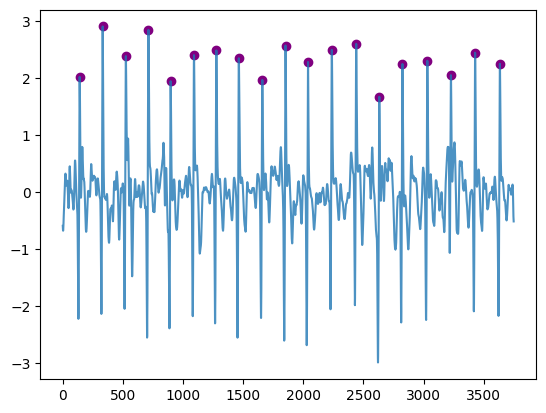

75.75757575757575
64.4145433724592


In [75]:
peaks, _ = find_peaks(acf_sin, distance=150)
plt.plot(acf_sin, alpha = 0.8)
plt.scatter(peaks, acf_sin[peaks], color='purple')
plt.show()

#стандартизую данные
new_acf_sin = scipy.stats.zscore(acf_sin)
peaks = np.array([i for i in peaks if new_acf_sin[i] > 3])

heart_rate = 60 / (np.median(np.diff(peaks)) / record.fs)
print(heart_rate)
heart_rate_1 = 60 / (np.mean(np.diff(peaks)) / record.fs)
print(heart_rate_1)